In [1]:
# first we will import the the dataset from kaggle and than visualize it

# IMports
import pandas as pd # for Data

# For viaualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for time stamps
from datetime import datetime as dt

In [2]:
# import data from yfinance
import yfinance as yf

# list of the companies
company_list = ['AAPL']

# set the time frame
end_date = dt(dt.today().year-2, dt.today().month, dt.today().day)

start_date = dt(end_date.year-10, end_date.month , end_date.day)

# get the data
data = yf.download(company_list, start=start_date, end=end_date)
test = data.copy()

[*********************100%***********************]  1 of 1 completed


In [3]:
# convert this raw data to a dataframe
apple_data = pd.DataFrame(data)
apple_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-10-08,23.102858,23.127144,22.718214,22.791786,19.329731,637994000
2012-10-09,22.808929,22.874643,22.269644,22.708929,19.259464,838597200
2012-10-10,22.847857,23.035000,22.750000,22.889643,19.412724,510356000
2012-10-11,23.089287,23.114286,22.432142,22.432142,19.024727,546081200
2012-10-12,22.484285,22.692142,22.332144,22.489643,19.073490,460014800


In [4]:
len(apple_data)

2515

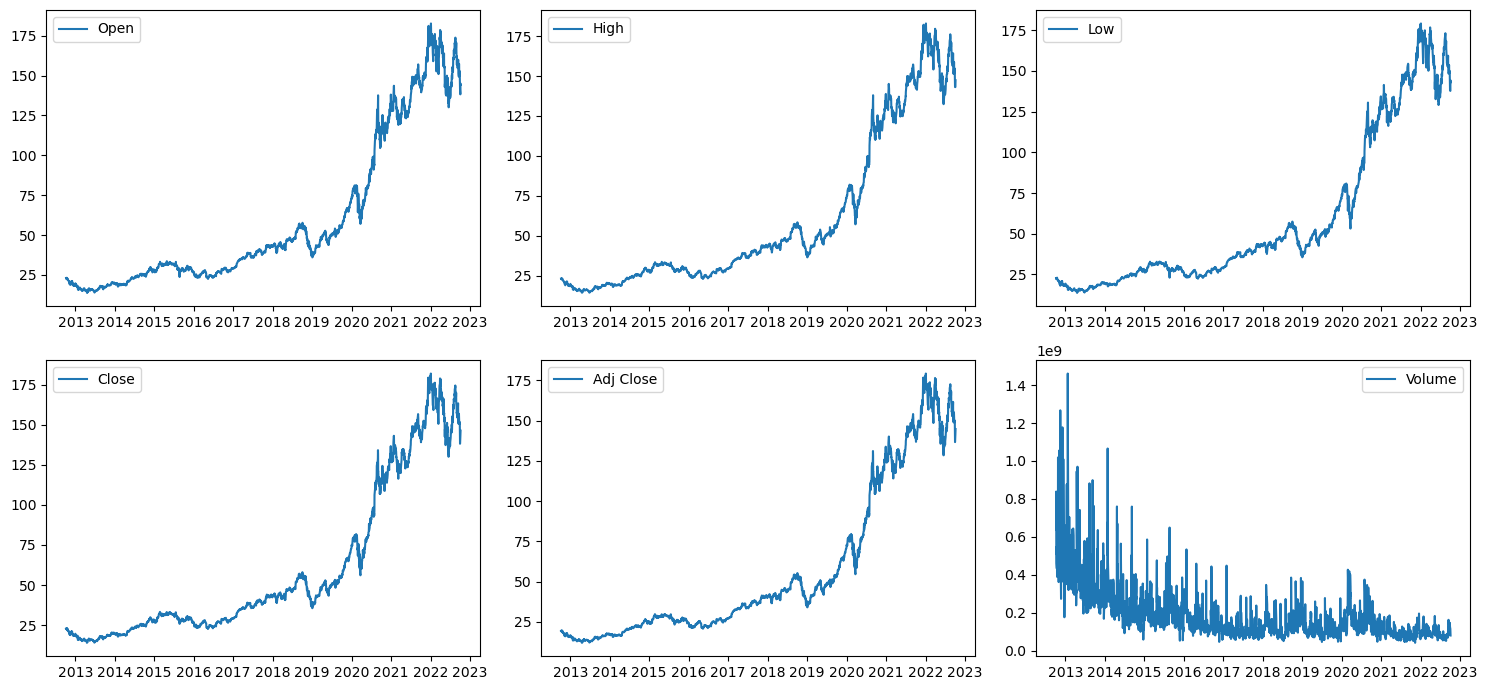

In [5]:
# visualise the data
# create subplaotes for each of the column
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(apple_data.columns):
    axes[i].plot(apple_data[col], label=col)
    axes[i].legend()

plt.tight_layout()  # auto size for better spacing
plt.show()

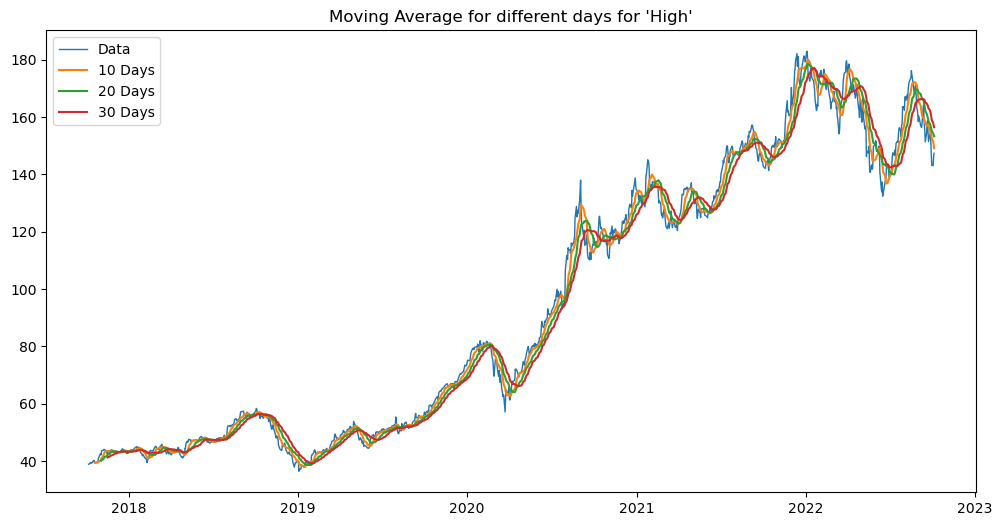

In [6]:
# the moving average for past 25 ,10 ,15 days

def Plot_Moving_Average(data, lag):
    plt.figure(figsize=(12,6))
    plt.plot(data, label='Data' ,linewidth=1)
    for i in range(len(lag)):
        plt.plot(data.rolling(lag[i]).mean(), label=f"{lag[i]} Days")
    plt.legend()
    plt.title(f"Moving Average for different days for '{data.name}'")
    plt.show()
# plot
last_half_data = apple_data['High'][len(apple_data)//2:]
Plot_Moving_Average(last_half_data,[10,20,30])

<h1> ARIMA


In [8]:
''' The procedure to follow(from now we will only consider the 'Open' coloun for analysis)
    1. Make the Series Stationary
    2. Estimate Model Parameters
    3. Fit the model
    4. Forecast
    5. Evaluate
'''
data = apple_data['Open']
data.index = pd.date_range(start=data.index[0], periods=len(data), freq='D')

<h2> 1. Make the series stationry

In [10]:
# first check is the series is already stationaty
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print(f"P value is {result[1]}")

P value is 0.9608685382301899


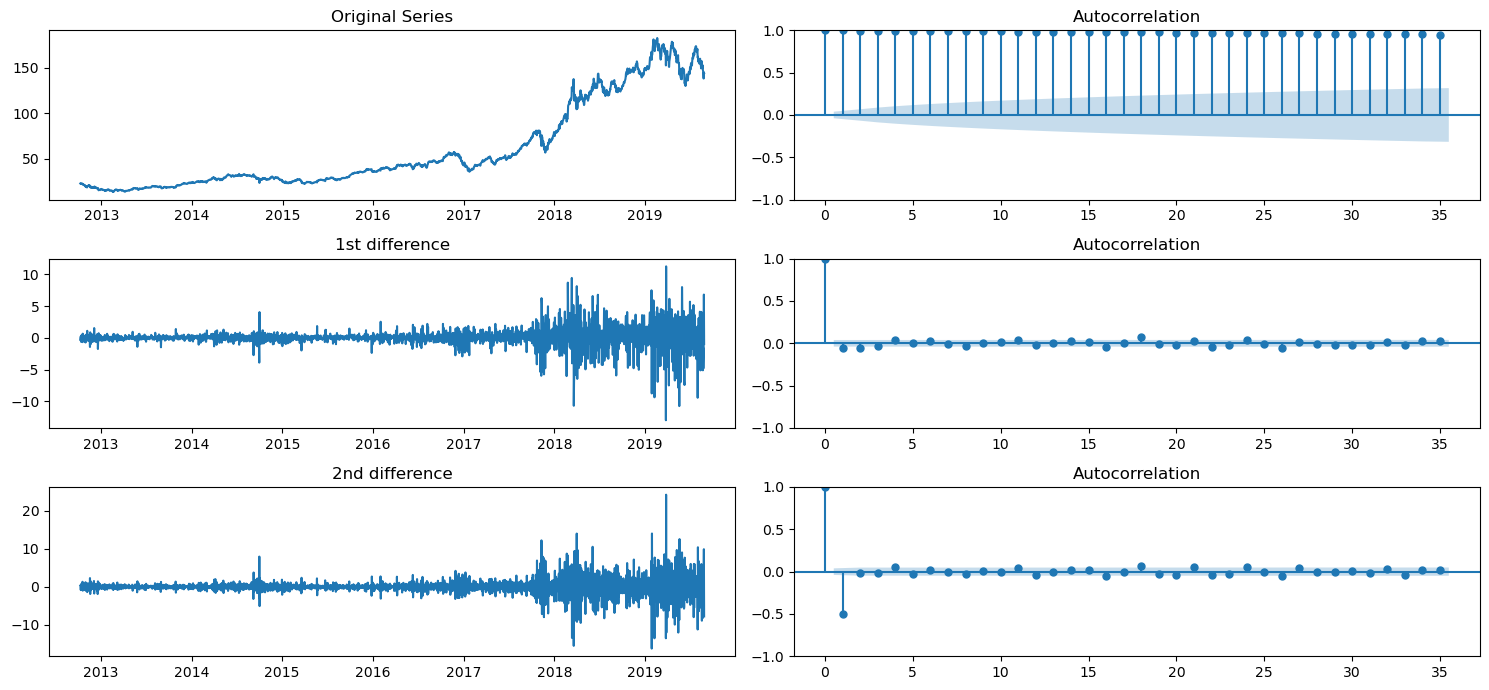

In [11]:
from re import sub
# as the p value is greater than the threshold(0.05) we will apply some transformations
# for e.g., diggerencing and will see the effect on the auto corelation(ACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# original series
fig, axex = plt.subplots(3,2, figsize=(15,7))
axex[0,0].plot(data); axex[0,0].set_title('Original Series')
plot_acf(data, ax=axex[0,1])

# 1st differencing
axex[1,0].plot(data.diff()); axex[1,0].set_title('1st difference')
plot_acf(data.diff().dropna(), ax=axex[1,1])

# 2nd differencing
axex[2,0].plot(data.diff().diff()); axex[2,0].set_title('2nd difference')
plot_acf(data.diff().diff().dropna(), ax=axex[2,1])

plt.tight_layout()  # auto size for better spacing
plt.show()

<h1> 2. Estimationg the parameters

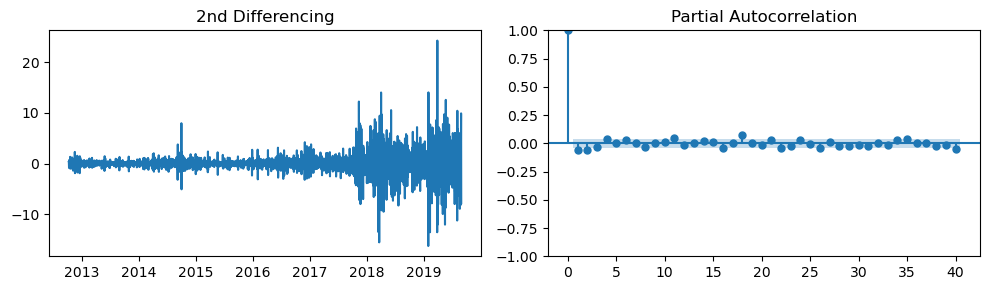

In [13]:
# for the value of p in arima(p,d,q) will palot he PACF plot and will see the spicks crossing the significent limits of the PACF plot

plt.rcParams.update({'figure.figsize':(10,3)})

fig, axes = plt.subplots(1, 2)
axes[0].plot(data.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.diff().dropna(), ax=axes[1], lags=40)
plt.tight_layout()
plt.show()


        as only one value is exceeding he limit pis allset to 1

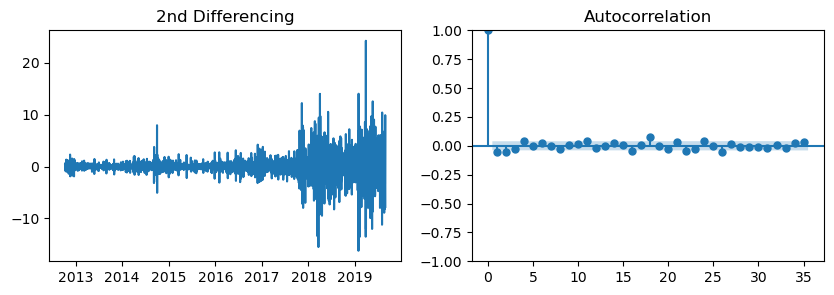

In [15]:
# for the value of p in arima(p,d,q) will palot he PACF plot and will see the spicks crossing the significent limits of the PACF plot

plt.rcParams.update({'figure.figsize':(10,3)})

fig, axes = plt.subplots(1, 2)
axes[0].plot(data.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_acf(data.diff().dropna(), ax=axes[1])

plt.show()

hence the value of q is also 1 from the graph

In [17]:
adfuller(data.diff().dropna())[1]

7.125188420582495e-17

<h2> 3. Fit the Model

In [19]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data, order=(1, 2, 1))  # here p=1, d=2, q=1
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(500)
predict = model_fit.predict()

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2515
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4677.653
Date:                Sun, 06 Oct 2024   AIC                           9361.305
Time:                        00:35:30   BIC                           9378.793
Sample:                    10-08-2012   HQIC                          9367.652
                         - 08-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0568      0.009     -6.440      0.000      -0.074      -0.039
ma.L1         -0.9993      0.001  -1230.223      0.000      -1.001      -0.998
sigma2         2.4162      0.027     88.176      0.0

<h2> 4. Forecasting

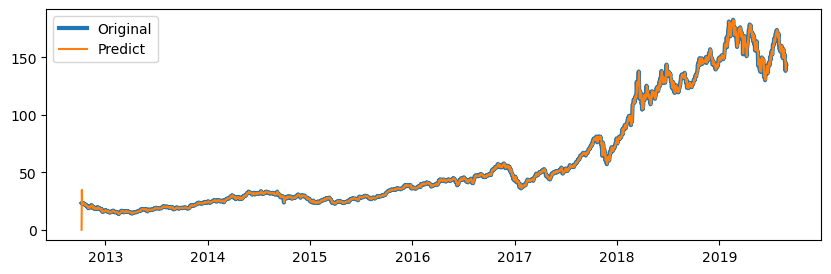

In [21]:
plt.plot(data, label='Original',linewidth = 3)
plt.plot(predict, label='Predict')
plt.legend()
plt.show()

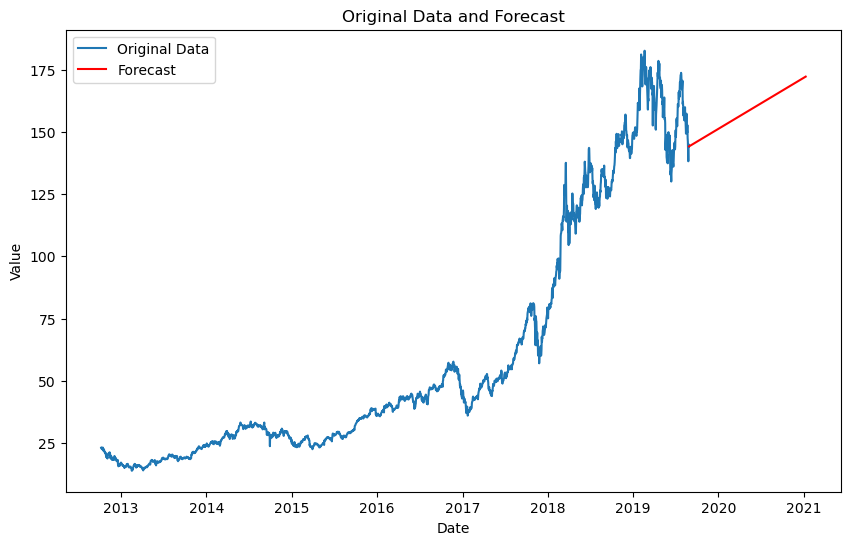

In [24]:
# Plot original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')  # Plot original data
plt.plot(forecast, label='Forecast', color='red')  # Plot forecasted values
plt.title('Original Data and Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


<h2> 5. Evaluate

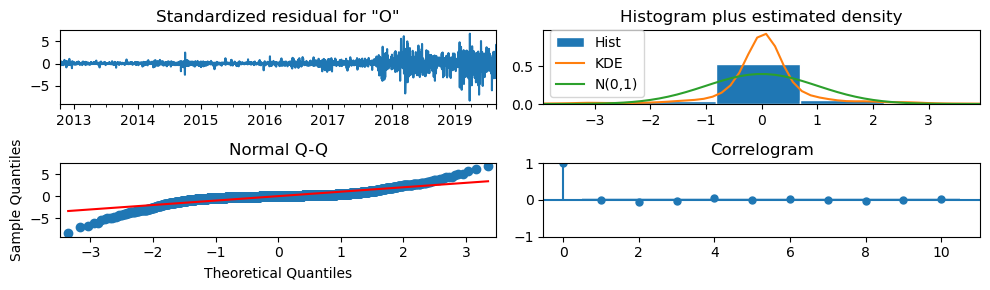

In [27]:
model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

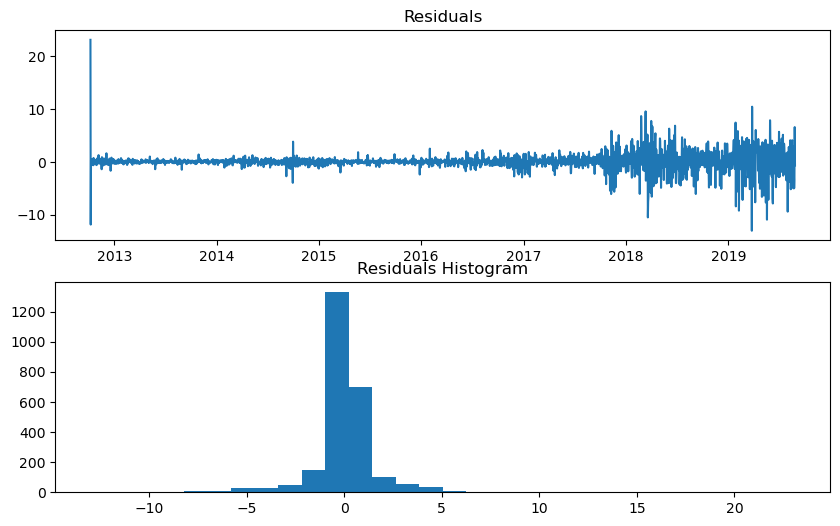

In [28]:
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Residuals Histogram')
plt.show()


In [ ]:
# hence the residuals are almost close to zero and most of these are zero( from the histogram)